<br>

# Curate A Dataset

This notebook curates the Yelp reviews dataset and ensures there are no duplicates, null values, and considers only restaurant establishments that are still in business.  
#### The end result of this notebook is the creation of a clean `reviews_dataset.csv` that will be used in subsequent `Jupyter` notebooks.  

<br>

In [61]:
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from enchant.checker import SpellChecker
from IPython.core.interactiveshell import InteractiveShell
from tqdm.notebook import tqdm_notebook
InteractiveShell.ast_node_interactivity = "all"

In [5]:
%matplotlib inline

# Set dataframe options to keep long data in columns from being truncated with ellipsis (...)
pd.set_option('max_colwidth', None)
# Set dataframe options to force display max columns
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_rows', 90)

spellChecker = SpellChecker("en_US")
tqdm_notebook.pandas()

Helper functions that is used throughout this notebook.  

In [53]:
def create_dataframe(file_path):
    '''
    Create a pandas dataframe from a JSON file indicated by the parameter file_path
    '''
    with open(file_path, encoding="utf8") as f:
        data = [json.loads(jsonObj) for jsonObj in f]
    return pd.DataFrame(data)


def df_info(df):
    '''
    A helper function - similar in functionality with `df.info()` but includes combined features: df.columns, df.dtypes, 
    df.isnull(), df.info(), df.nunique()
    '''
    print('\nShape : {}'.format(df.shape))
    print('Number of duplicates : {}\n'.format(df.duplicated().sum()))

    print('{:^35} {:^12} {:^12} {:^8} {:>10}\n'.format('COLUMNS', 'DATA TYPE', 'HAS NULL', 'COUNTS', '# UNIQUE'))
    for i, v in enumerate(df.columns):
        col = df[v]
        dtype = type(col.iloc[0]).__name__
        
        if dtype=='dict':
            keys = set([item for val in col.values if val is not None for item in list(val.keys())])
            col_nunique = len(keys)
        else:
            col_nunique = col.nunique()
        
        print(' {:>2}.  {:<30} {:<12} {:^10} {:>8} {:>10}'.format(i+1, v, dtype, \
                                                                  str(col.isnull().any()), col.count(), \
                                                                  col_nunique))    # col.nunique()

# Data-cleaning helper functions

# list of cjk codepoint ranges (added Japanese at the bottom)
# tuples indicate the bottom and top of the range, inclusive
cjk_ranges = [
        ( 0x4E00,  0x62FF),
        ( 0x6300,  0x77FF),
        ( 0x7800,  0x8CFF),
        ( 0x8D00,  0x9FCC),
        ( 0x3400,  0x4DB5),
        (0x20000, 0x215FF),
        (0x21600, 0x230FF),
        (0x23100, 0x245FF),
        (0x24600, 0x260FF),
        (0x26100, 0x275FF),
        (0x27600, 0x290FF),
        (0x29100, 0x2A6DF),
        (0x2A700, 0x2B734),
        (0x2B740, 0x2B81D),
        (0x2B820, 0x2CEAF),
        (0x2CEB0, 0x2EBEF),
        (0x2F800, 0x2FA1F),
        ( 0x3041,  0x3096),
        ( 0x30A0,  0x30FF)
    ]

def is_cjk(char):
    char = ord(char)
    for bottom, top in cjk_ranges:
        if char >= bottom and char <= top:
            return True
    return False


def containsChineseChars(s):
    #return any(map(is_cjk_, s))
    # return true only if Chinese/Japanese characters exist for a certain percentage
    return (sum(map(is_cjk, s))/len(s)) > .4


def isHttp(s):
    words = s.split()
    if len(words) <= 10 and 'http' in s:
        return True
    return False


def singleLongShortWord(s):
    words = s.split()
    if len(words) == 1 and len(words[0]) > 20:
        return True
    elif len(words) == 1 and len(words[0]) == 1:
        return True
    return False


def containsLetters(s):
    if re.search('[a-zA-Z]', s) is None:
        return False
    return True


def in_english(quote):
    spellChecker.set_text(quote.upper())
    errors = [err.word for err in spellChecker]
    # setting a threshold of 20% of quote contains errors; this will be more forgiving for longer reviews which is ok
    # longer reviews tend to be more legitimate
    return False if (len(errors) > int(len(quote.split())*.2)) else True
    #return False if (len(errors) > 4) else True

## Business Dataset

Reviews are from different type of establishments. This needs to be filtered down to only dine/drink type of establishments where our sentiment analysis will focus on.  To determine the type of establishments, the business dataset will need to be loaded where it contains features that can be keyed on for filtering.  

In [7]:
business_json = '../yelp_dataset/yelp_academic_dataset_business.json'
business_df = create_dataframe(business_json)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   address       209393 non-null  object 
 3   city          209393 non-null  object 
 4   state         209393 non-null  object 
 5   postal_code   209393 non-null  object 
 6   latitude      209393 non-null  float64
 7   longitude     209393 non-null  float64
 8   stars         209393 non-null  float64
 9   review_count  209393 non-null  int64  
 10  is_open       209393 non-null  int64  
 11  attributes    180348 non-null  object 
 12  categories    208869 non-null  object 
 13  hours         164550 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 22.4+ MB


#### Restaurants Only

The `categories` feature holds the information for the type of establishment.  This will be used to filter the data.

In [8]:
# Business criteria: Restaurants, Bars, Pub, or wherever there's Food
eat_drink_business_df = business_df.query('not categories.isnull() and \
                  (categories.str.contains("Food") or categories.str.contains("Restaurants") \
                   or categories.str.contains("Bars") or categories.str.contains("Pub"))', 
                  engine='python')

eat_drink_business_df[['name', 'categories']].sample(5)

,name,categories
170408,Mandalay Noodle World Restaurant,"Restaurants, Asian Fusion"
157656,Nam Vietnamese Kitchen,"Vietnamese, Restaurants"
30753,Manhattan Streets,"Food, Hot Dogs, Restaurants"
131383,Citizen Pie,"Restaurants, Pizza"
96927,The Roosevelt,"American (New), Restaurants, Nightlife, Bars"


> Sample data of the type of establishments where customer reviews will come from.

<br>

#### Establishments that are still in business

The `is_open` feature of the business dataset indicates whether or not the establishment is still in business or not.

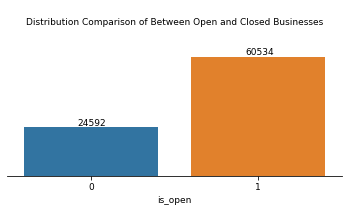

In [10]:
results = eat_drink_business_df.is_open
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 'axes.labelsize' : 9, 
          'xtick.labelsize' : 9, 'axes.titlesize':9}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=False, figsize=(6, 2.3))
ax = fig.gca()
tmp = ax.set_title('\nDistribution Comparison of Between Open and Closed Businesses\n\n');
p = sns.countplot(x=results, ax=ax)
ax.yaxis.set_visible(False)
counts=pd.Series(results).value_counts().sort_values(ascending=True)
for i, count in enumerate(counts):
    tmp = ax.text(i-.08, count+1000, '{}'.format(count), fontsize=9);


> Proportion of businesses that are still open.


The `business_id` is no longer needed and can be removed.

In [65]:
reviews_dataset.drop(['business_id'], axis=1, inplace=True)

## Reviews Dataset

In [12]:
review_json = '../yelp_dataset/yelp_academic_dataset_review.json'
reviews_df = create_dataframe(review_json)
df_info(reviews_df)


Shape : (8021122, 9)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  review_id                      str            False     8021122    8021122
  2.  user_id                        str            False     8021122    1968703
  3.  business_id                    str            False     8021122     209393
  4.  stars                          float64        False     8021122          5
  5.  useful                         int64          False     8021122        266
  6.  funny                          int64          False     8021122        209
  7.  cool                           int64          False     8021122        200
  8.  text                           str            False     8021122    7999488
  9.  date                           str            False     8021122    7853102


> **Note :** There are `8M` instances in this dataset. With this size, training a model will take time to complete.

The problem domain is around sentiment analysis of reviews.  
The reviews are stored in the `text` feature so other features in the reviews dataset are not needed and can be removed.  

In [13]:
reviews_dataset = reviews_df.drop(['review_id', 'user_id', 'useful', 'funny', 'cool', 'date'], axis=1)

Filter the restaurants/bars that are still in business using the business dataset.

In [14]:
establishments_still_in_business = eat_drink_business_df.query('is_open == 1').business_id
reviews_dataset = reviews_dataset.query('business_id in @establishments_still_in_business')
df_info(reviews_dataset)


Shape : (4733942, 3)
Number of duplicates : 9393

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     4733942      60534
  2.  stars                          float64        False     4733942          5
  3.  text                           str            False     4733942    4722100


In [15]:
len(reviews_dataset)/len(reviews_df)

0.590184515333391

> Considering only restaurant type establishments and those that are still in business, the reviews dataset is reduced to `59%` of its original size but with `4.7M` it is still a substantial size of data.

Since this is a type of classification type of problem, the `stars` need to be collated into three class labels, namely: `negative` (0), `neutral`(1), and `positive`(2).  Before collating, review distribution of the ratings.

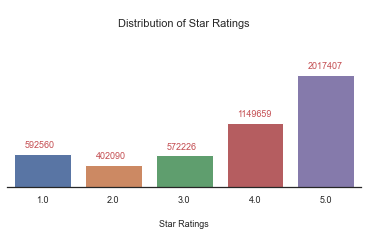

In [16]:
sns.set(style="white")
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 
          'axes.labelsize' : 9, 'xtick.labelsize' : 9, 'ytick.labelsize' : 9}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=True, figsize=(5, 2.4))
ax = fig.gca()
sns.countplot(reviews_dataset.stars, ax=ax)

counts=reviews_dataset.groupby('stars').count().text
for i, txt in enumerate(ax.get_xticklabels()):
    count = counts[float(txt.get_text())]
    ax.text(i-.25, count+100000, '{}'.format(count), fontdict={'fontsize': 9}, c='r')

ax.set_xlabel('\nStar Ratings')
ax.yaxis.set_visible(False)
fig.suptitle('\nDistribution of Star Ratings', y=1.3, fontsize=11);
ax.set_xticklabels(labels=[lbl.get_text().title() for lbl in ax.get_xticklabels()]);


> Patrons rate establishments from 1 through 5 with 5 being the highest. The stars value will be able to provide the appropriate label to the sentiments.
However in lieu of the star ratings, this can be collated into: negative, neutral, positive. Reviews with 1 and 2 will fall into the negative, 3 into neutral, 4 and 5 into positive.

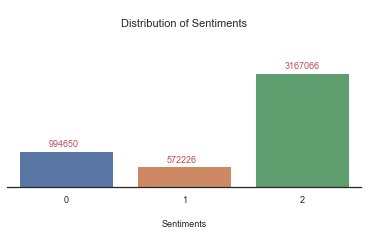

In [17]:
# this maps stars 1-2 -> 0, 3 - > 1, 4-5 -> 2 where 0 negative, 1 neutral, 2 is positive
reviews_dataset['sentiment'] = reviews_dataset['stars'].map({1:0, 2:0, 3:1, 4:2, 5:2}, na_action='ignore')

sns.set(style="white")
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 
          'axes.labelsize' : 9, 'xtick.labelsize' : 9, 'ytick.labelsize' : 9}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=True, figsize=(5, 2.4))
ax = fig.gca()
sns.countplot(reviews_dataset.sentiment, ax=ax)

counts=reviews_dataset.groupby('sentiment').count().text
for i, txt in enumerate(ax.get_xticklabels()):
    count = counts[int(txt.get_text())]
    ax.text(i-.15, count+100000, '{}'.format(count), fontdict={'fontsize': 9}, c='r')

ax.set_xlabel('\nSentiments')
ax.yaxis.set_visible(False)
fig.suptitle('\nDistribution of Sentiments', y=1.3, fontsize=11);
ax.set_xticklabels(labels=[lbl.get_text().title() for lbl in ax.get_xticklabels()]);

> **Note :** Clearly there is an imbalance data.  The imbalance will be addressed in a separate notebook.

**Test the changes**.  All three queries should **not** return any values.

In [18]:
reviews_dataset.query('stars == 3 and (sentiment == 2 or sentiment == 0)')
reviews_dataset.query('stars < 3 and (sentiment == 1 or sentiment == 2)')
reviews_dataset.query('stars > 3 and (sentiment == 0 or sentiment == 1)')

,business_id,stars,text,sentiment


,business_id,stars,text,sentiment


,business_id,stars,text,sentiment


Now that the sentiment feature has been created, there is no need for the stars feature and can be removed.

In [19]:
reviews_dataset.drop(['stars'], inplace=True, axis=1)

# Review changes made on this dataset.
df_info(reviews_dataset)


Shape : (4733942, 3)
Number of duplicates : 9969

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     4733942      60534
  2.  text                           str            False     4733942    4722100
  3.  sentiment                      int64          False     4733942          3


From above `Number of duplicates`, it seems duplicates now appear in the dataset and needs to be investigated.  
Review an example of a duplicate.

In [21]:
reviews_dataset[1000:10500][reviews_dataset[1000:10500].duplicated(subset=['text'], keep=False)]

,business_id,text,sentiment
12457,yvLmGbFpfSY9YUKdabU_3g,"Some cravings you just can't ignore! Today was our first time visiting Popcorn Heaven in Ballantyne. The smells alone are worth the trip! We were immediately greeted by the sales clerk who was helping another customer. (Call me old fashioned, but I like to be acknowledged. Her smile made us feel very welcomed!) Then Daniel the owner welcomed us and explained the menu, purchase options & specials. This place has folks pouring in & they all knew what they wanted. While my husband and I were trying to make a decision on flavors, Daniel graciously offered samples. It was...heavenly! Deee-lish! Fresh! Popcorn Heaven also ships! Prices were great when compared to online companies. I love shopping local & Popcorn Heaven will definitely be keeping my business! Oh, one last thought- Daniel said they make nice gift baskets for Valentines day. Seriously friends, give Popcorn Heaven a try!",2
15037,yvLmGbFpfSY9YUKdabU_3g,"Some cravings you just can't ignore! Today was our first time visiting Popcorn Heaven in Ballantyne. The smells alone are worth the trip! We were immediately greeted by the sales clerk who was helping another customer. (Call me old fashioned, but I like to be acknowledged. Her smile made us feel very welcomed!) Then Daniel the owner welcomed us and explained the menu, purchase options & specials. This place has folks pouring in & they all knew what they wanted. While my husband and I were trying to make a decision on flavors, Daniel graciously offered samples. It was...heavenly! Deee-lish! Fresh! Popcorn Heaven also ships! Prices were great when compared to online companies. I love shopping local & Popcorn Heaven will definitely be keeping my business! Oh, one last thought- Daniel said they make nice gift baskets for Valentines day. Seriously friends, give Popcorn Heaven a try!",2


> Selecting a subset/range of rows from the dataset, confirms that there are indeed duplicates.  It seems that after converting the JSON object into a dataframe, the `duplicated` function did not seem to work initially that's why it did not show up in the first round of review of the dataset.

Duplicates have no value and is a waste in resource so these need to be dropped.

In [22]:
# capture duplicates before removing; may need metrics later on
duplicate_rows = reviews_dataset[reviews_dataset.duplicated()]

reviews_dataset.drop_duplicates(inplace=True)

# Confirm duplicates no longer exist.
df_info(reviews_dataset)


Shape : (4723973, 3)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     4723973      60534
  2.  text                           str            False     4723973    4722100
  3.  sentiment                      int64          False     4723973          3


> After the duplicates have been removed, it is odd that the unique counts for `text` does not match total counts.

Check for duplicates only on text column.  There may be duplicates in text but vary in sentiment. If this is indeed true, this will affect the prediction performance of the model.

In [23]:
reviews_dataset[10000:30000][reviews_dataset[10000:30000].text.duplicated(keep=False)]

,business_id,text,sentiment
17351,7sb2FYLS2sejZKxRYF9mtg,"Update: \n\nAlright. So even though Sakana has its days when it's super amazing. Sometime I shake my head and wonder wth is going on. Today I have officially been eating here consistently for over a year. I just met the third owner of Sakana and am wondering how is it that she co-owns this place and was puzzled when I asked for half rolls... the manager was in a panic the entire time and somehow we got someone else's roll, and jacob didn't get half of this order. Do NOT try the wasabi taco. It is soooooo Gross. And apparently week day service is absolute shit. To add to that, the only reason why we got a table so quickly is because the couple got up and left since they hadn't been serviced yet. Did I mention it took my boyfriend 25 minutes to get his credit card back. \n\n\n\n\n-------\nI rarely give high reviews. But I really like this place. My boyfriend and I come here all the time, at least 3 times a month. This place is really well priced for what they have. \n\n$23-25 all you can eat sushi, including drinks, appetizers and desserts. \n\nAs far as the quality of the sushi, it's not fantastic but pretty good. \n\nThe only downside I would have to say is, don't experiment too much. I love trying different things but usually end up regretting most of my choices. The appetizer, ""the shit"" is probably the best experimental item on the menu.\n\nYou may have to wave down the server a few times to order unless you sit at the bar, you only have to wave them down for non roll items",0
21136,7sb2FYLS2sejZKxRYF9mtg,"Update: \n\nAlright. So even though Sakana has its days when it's super amazing. Sometime I shake my head and wonder wth is going on. Today I have officially been eating here consistently for over a year. I just met the third owner of Sakana and am wondering how is it that she co-owns this place and was puzzled when I asked for half rolls... the manager was in a panic the entire time and somehow we got someone else's roll, and jacob didn't get half of this order. Do NOT try the wasabi taco. It is soooooo Gross. And apparently week day service is absolute shit. To add to that, the only reason why we got a table so quickly is because the couple got up and left since they hadn't been serviced yet. Did I mention it took my boyfriend 25 minutes to get his credit card back. \n\n\n\n\n-------\nI rarely give high reviews. But I really like this place. My boyfriend and I come here all the time, at least 3 times a month. This place is really well priced for what they have. \n\n$23-25 all you can eat sushi, including drinks, appetizers and desserts. \n\nAs far as the quality of the sushi, it's not fantastic but pretty good. \n\nThe only downside I would have to say is, don't experiment too much. I love trying different things but usually end up regretting most of my choices. The appetizer, ""the shit"" is probably the best experimental item on the menu.\n\nYou may have to wave down the server a few times to order unless you sit at the bar, you only have to wave them down for non roll items",2


> As suspected, there are indeed duplicate reviews and most concerning, sentiment is different.

Get a count of this anomaly.

In [24]:
dup_revews_anomaly = reviews_dataset[reviews_dataset.text.duplicated(keep=False)]
len(dup_revews_anomaly)

3591

To avoid confusing the model, drop duplicates in the `text` feature.  However, which one should be kept since duplicate text reviews vary in sentiment?  Its difficult to gauge which of the review is genuine so all these are discarded instead.

In [25]:
reviews_dataset.drop(dup_revews_anomaly.index, inplace=True)

# confirm
print('Number of duplicates in "text" column : {}'.format(reviews_dataset.text.duplicated().sum()))

Number of duplicates in "text" column : 0


Next, build some level of insight in the reviews text.  This will help formulate predictive theories during model building.

In [26]:
review_lengths = [len(x.split()) for x in reviews_dataset.text.values]

# plot lenghts of reviews
x=pd.Series(np.array(review_lengths))

# IQR
IQR = x.describe()['75%'] - x.describe()['25%']

# IQR multiplier to set the whisker/boundary for outliers (default is 1.5)
IQR_multiplier = 1.5

# Defining threshold as the 3rd Quartile + (IQR * IQR_multiplier)
outlier_threshold = math.floor(x.describe()['75%'] + (IQR*IQR_multiplier))

print('\nStatistically accepted boundary for outliers : {}\n'.format(outlier_threshold))


Statistically accepted boundary for outliers : 267



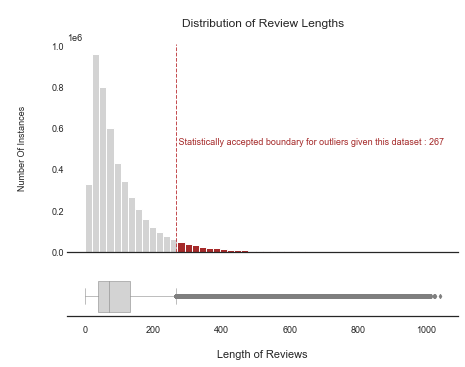

In [27]:
params = {'axes.titlesize':'9', 'xtick.labelsize':'9', 'ytick.labelsize':'9', 'axes.spines.top':False,
          'axes.spines.right': False}
matplotlib.rcParams.update(params)
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .15)})
tmp = ax_hist.set_title('\nDistribution of Review Lengths\n', fontdict={'fontsize': 12});
tmp = ax_hist.set_ylabel('\nNumber Of Instances\n\n', fontdict={'fontsize': 9})
ax_hist.tick_params(bottom="off", length=0)
tmp = ax_hist.axvline(x=outlier_threshold, c='r', linestyle='--', linewidth=1)
text = ' Statistically accepted boundary for outliers given this dataset : {}\n'
tmp = ax_hist.annotate(text.format(int(outlier_threshold)), (outlier_threshold+1, x.count()/10), fontsize=9, color='brown')
ax_box.spines['left'].set_visible(False)
ax_box.yaxis.set_visible(False)

res = x.hist(figsize=(7, 5), color='lightgray', grid=False, ax=ax_hist, bins=50)

for idx, rec in enumerate(res.patches):
    if rec.xy[0] > outlier_threshold-1:
        res.patches[idx].set_fc('brown')  
bx = sns.boxplot(x, ax=ax_box, fliersize=3, color='lightgray', linewidth=.5, whis=IQR_multiplier)
tmp = ax_box.set_xlabel('\nLength of Reviews', fontdict={'fontsize': 11})
#plt.tight_layout();

> The distribution is highly-skewed due to some instances with extremely long reviews.  
> There's a large distribution with short reviews.

Print out examples from both short and long reviews and ensure validity.

In [28]:
long_reviews  = [ r for r in reviews_dataset.text if len(r.split()) > 267]
short_reviews = [ r for r in reviews_dataset.text if len(r.split()) <= 2 ]

In [48]:
# print some random short reviews
pd.Series(short_reviews).sample(10, random_state=19)

583                                フォーと生春巻きを頂きました。味はどちらも美味しかったですが、接客が不親切でお皿や床が汚れていました。お皿は伝えたら直ぐに取り替えてくれましたが、料理の衛生も心配になります。
620                                                             很標準的美式餐廳，一道主餐配兩道小菜，雞肉軟嫰多汁，小朋友也喜歡，用餐環境稍微老舊，但冷門時段仍有供餐，是很難得的。
697       紅燒牛肉麵很好吃，蘿蔔糕也不錯，鍋貼及小籠包的肉餡稍微甜了一點。燒餅不錯，可是油條炸的太油了。還有其他的台灣小吃，蚵仔煎，滷肉飯，油豆腐粉絲，大腸麵線。如果你有機會來賭城，不妨來這裡試一試。這裡的服務態度很好，老闆非常客氣。
646                                    Our burgerをオーダー。バンズが軽く、パテがジューシーで肉の旨味がしっかり味わえました！揚げたてフレンチフライもサイコー！ウエイターもイケメン揃いでリピ決定！
405                                                                                                            Delicious!!
317                                                            ベガスのKorean BBQ。ちょっと値段設定は高いですが本場韓国並みに美味しかったです。オススメは冷麺。最高でした。
168                                       這家的川菜味道不錯，可惜料變少了。\n我來了兩次，服務冷淡，用餐環境不舒服。我們用餐的小圓桌是朔膠的，感覺好像隨時會倒，很不安全，服務人員的態度讓我不會想再去。
632    店員さんも優しく、メニューを一から全て説明してくれました。店内も綺麗に清掃されており、バルコニーに出ることも出来るので、みなさん写真をたくさん撮っていました。アイスにしては値段が高かった気もしますが、美味しかったので良かったです。
531             

> Short reviews contain emoticons, Chinese and Japanese words, hyper-links, one-word expression, etc.

In [51]:
# print random long reviews
pd.Series(long_reviews).sample(1, random_state=2)

171360    I liked this place! \n\nWe ordered a small jerk chicken, two pieces of the fried chicken and a fried bread dumpling, I'm not sure what this was called! The lady serving us was really sweet but it took her a while to put the food together and punch the order into the computer. I'll chalk this up to them being new. \n\nThe jerk chicken was pretty good. Very different from what I've had before. The sauce has more of a sweet barbecue flavour as opposed to the savory jerk flavour that I'm used to, it was good, just not what I was expecting. It was spicy and flavourful. The rice wasn't great, it was overcooked and was lacking flavour. Hopefully this is something that will be improved over time, or maybe we had an off day. The fried chicken was not bad. I don't love that this is pre-cooked and kept on a hot plate. Fried chicken should really be fresh, but I guess it's not a fried chicken restaurant so I shouldn't be expecting much. I think my favourite part of the meal was the bread

> This example of a long review looks valid.  Some patrons do take some time to express their experience.

Clearly, the reviews need some scrubbing to remove invalid content.

`1.` Remove reviews that contains a high number of non-English characters.

In [54]:
non_english_charcode = reviews_dataset[reviews_dataset.progress_apply(lambda row: containsChineseChars(row.text), axis=1)]
len(non_english_charcode)
non_english_charcode.sample(3)

1695

,business_id,text,sentiment
1176499,127lSDZ1lvVMrhEet6un5Q,"夏天熱辣辣，去逛yonge and lawrence Festival,行到口干就想穩地方坐下飲下野。剛好經過呢間麥當勞，且做緊夏天冰沙特飲優惠。拿拿聲系自助下單機度點左。芒果冰沙的芒果味不算濃，一般啦，不過2元而已，吾要求太高了",1
3657823,dxeu5YQIzw0jOp1cSVkimg,値段も良心的で味も美味しい！ おススメ料理の中から 蟹味噌の天ぷらとシャケクリームコロッケを頼んだけど、その2つは ちょっと微妙だったけど、 それ以外が日本の居酒屋メニューでコッチにあまり無いメニューなどでとっても美味しくて楽しみました。 混んでた割にはすぐ入れて、働いてる人達もとっても親切でした。,2
5088642,39nPYUxkRn8SQY29C322UQ,有人外卖翻屋企吃，觉得不错！就记住左呢个品牌的芝士蛋糕。去开逛mall，知道呢度有门店，就八卦去看下顺便买个。系商场的一楼，店铺缩左埋最里面，圆圈设计的柜台，几得意。菜单好简单，只卖2种产品：芝士蛋糕和芝士挞。红色包装盒好适合新年或圣诞。芝士味浓度适中，中意距多吃都唔太漏,2


In [55]:
# Drop by index
reviews_dataset.drop(non_english_charcode.index, inplace=True)

<br>

`2.` Check for reviews that contain limited text and contain mostly hyper-text links.

In [56]:
reviews_hypertext_links = reviews_dataset[reviews_dataset.progress_apply(lambda row: isHttp(row.text), axis=1)]
len(reviews_hypertext_links)
reviews_hypertext_links.sample(3)

58

,business_id,text,sentiment
1671304,bZgfnQtLXly82_XmLBqOwQ,"Wow, this good personality oh, very good!!!!!!!http://www.pcbatteries.ca/",2
4129536,5P7zzVhWvO8nXGPdy7xqhw,https://www.saveology.com/phoenix-west\n\n$5 for $10 worth of Lamar's goodness!,2
5993423,Hx6HNJfEGgllQ3-dyoNDbA,http://www.cabarrusmagazine.com/2017/08/16/152346/cabarrus-county-restaurant-health-inspection-report-7-17-17-8-16-17-,0


In [57]:
# Drop by index
reviews_dataset.drop(reviews_hypertext_links.index, inplace=True)

<br>

`3.` Check and clean reviews that contain only a single word but comprises of only a series of characters with no meaning.

In [58]:
reviews_single_long_word = reviews_dataset[reviews_dataset.progress_apply(lambda row: singleLongShortWord(row.text), axis=1)]
len(reviews_single_long_word)
reviews_single_long_word.sample(3)

22

,business_id,text,sentiment
5405348,dNr7VKRti8dXWE-jzfVBtQ,If.....you......want.....to.....get.....a......good......meal.....in......a........reasonable.......amount.........of......time.......then.......you.......should.......probably........look.......elsewhere.......this........restaurant........needs.......some........serious.....help.....there........are......dishes.......everywhere......servers......do.......not.......pick......up......plates.....from......tables.......it.......takes......forever.....to......get.......food.......and.......when......you......do......it.......is......usually.......luke.......warm.....I........imagine.......if.......you.....just......want......to......drink......beers.......it......would......be......fine.......but.......be.......prepared......to......wait............................forever....................to......................get.................................your........................food.....................because......................there..............................................is................no...............................................................................sense...............................of......................................................urgency.................................here.,0
4850243,Gml97gSULiA6HFjie01d3Q,#notedible#doubleyuk!yuk!#neveragain,2
2133315,_XN-GwzZwAyIqLKJsl2htg,G,0


In [59]:
# Drop by index
reviews_dataset.drop(reviews_single_long_word.index, inplace=True)

<br>

`4.` Check and clean reviews that does not contain any text and only numeric.

In [62]:
reviews_numeric_only = reviews_dataset[reviews_dataset.progress_apply(lambda row: not containsLetters(row.text), axis=1)]
len(reviews_numeric_only)
reviews_numeric_only.sample(3)

6

,business_id,text,sentiment
327621,0cf-w9PK5gLkBkitL3bdqw,..,0
5882538,3LWsVfsSmb_Nzbi2YQ-NIA,.....\n\n\n\n\n....???!!!,2
6416435,tox8x-lk9KNmGSq-fuNH9Q,好喝好吃 装修好看啊！！！！！！！！！！！！！！！！！！！？？？？？？？？？？！？！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！,2


In [63]:
# Drop by index
reviews_dataset.drop(reviews_numeric_only.index, inplace=True)

<br>

`5.` Check and clean reviews that are not in english language.

In [64]:
non_english_language = reviews_dataset[reviews_dataset.progress_apply(lambda row: not in_english(row.text), axis=1)]
len(non_english_language)
non_english_language.sample(5)

29308

,business_id,text,sentiment
1229048,VV2yZ-4KJau3sWRfqzzosg,"Micro brasserie possibilté de prendre une petite bouchée , a noter après 23h les jeunes adultes y sont mais durant la journée on peut siroter tranquillement sans se faire bousculer!",2
5075148,6WJr5EokVAEEd2m0tVOupw,"Le 747 est le bus desservant directement les voyageurs du centre ville jusqu'à l'aéroport et vice versa. Le trajet simple est à 10$. À savoir qu'il vaut mieux avoir l'appoint sur vous car le chauffeur ne redonne pas la monnaie. \n\nIl y a plusieurs formules, pour tout un weekend c'est 13$ pour la semaine (sans le weekend) c'est 20$ et pour semaine + weekend c'est 24$. Le prix reste assez élevé pour un simple trajet mais bon vous avez de quoi poser vos bagages, pas mal de place et surtout ... Il y a ... Le .... WIFI GRATUIT!!!\n\nLes horaires, trajets + les noms d'arrêt sont écris à la gare de Montréal ainsi qu'à l'aéroport.",2
4395398,rxK3qr76Ib6aYqPLCN9fUA,"Une belle pâtisserie du Moyen-Orient (Irak, je crois...), bien située au centre-ville près du métro Guy.\n\nOn peut manger sur place, prendre un thé à la menthe et un petit gâteau ou pour emporter. \n\nEssayez les pâtisseries: mini baklavas, namourra et petits biscuits, ils sont délicieux et c'est super pour offrir en cadeau. Et les prix sont vraiment abordables. Quoi de mieux?",2
969964,7MacgLhLGiXvZoZdhgeKPw,"Quel magnifique endroit ! Vintage et coquet, il y a de grandes tables où l'on peut travailler en paix (WiFi gratuit via l'Île Sans Fil). J'y allais simplement pour étudier en sirotant un café, mais impossible de résister à leur étalage de pâtisseries maison : cake au thé à la rose, sablés au chocolat à la fleur de sel, pots de crème caramel... Vraiment alléchant ! Le latte à la lavande était tout à fait original, l'arôme de lavande était bien dosé, ni trop présent ni trop subtil. Le service était irréprochable. La musique était agréable et pas trop forte. J'ai adoré ma première visite et j'y retournerai sans faute.",2
3821409,mRxUCEoUUe-XsEYS1SlrTA,I love shopping at this store. Check out my YouTube video of my most recent shopping trip here. \n\nhttps://youtu.be/tY1Bvuegt7w\n\nNew video up on my YouTube channel. Link in my bio. Come along with me as I shop at my local Japanese market. #japan #japanese #japanesemarket #japanesefood #takoyaki #sushi #japanesecurry #tonkatsu #ramen #とんかつ #すし #らめん #たこやき #やきそば #のり,2


In [78]:
# Drop by index
reviews_dataset.drop(non_english_language.index, inplace=True)

Combine all the bad data identified in steps 1 - 5 and then save for analysis later on so that we don't need to run the cleaning process again which takes a long time to complete.

- non_english_charcode  
- reviews_hypertext_links  
- reviews_single_long_word  
- reviews_numeric_only  
- non_english_language

In [76]:
# individual sets of bad data
non_english_charcode.to_csv('../yelp_dataset/non_english_charcode.csv', index=False)
reviews_hypertext_links.to_csv('../yelp_dataset/reviews_hypertext_links.csv', index=False)
reviews_single_long_word.to_csv('../yelp_dataset/reviews_single_long_word.csv', index=False)
reviews_numeric_only.to_csv('../yelp_dataset/reviews_numeric_only.csv', index=False)
non_english_language.to_csv('../yelp_dataset/non_english_language.csv', index=False)

# concatenation of the individual files
bad_data = pd.concat([non_english_charcode, reviews_hypertext_links, reviews_single_long_word, 
                      reviews_numeric_only, non_english_language])
bad_data.to_csv('../yelp_dataset/bad_data.csv', index=False)

Review the collected data that were removed from the dataset.

In [73]:
df_info(bad_data)


Shape : (31089, 3)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False       31089       9626
  2.  text                           str            False       31089      31089
  3.  sentiment                      int64          False       31089          3


> There were 31K total bad data removed from the dataset.

Review the cleaned dataset.

In [79]:
df_info(reviews_dataset)


Shape : (4689293, 3)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     4689293      60460
  2.  text                           str            False     4689293    4689293
  3.  sentiment                      int64          False     4689293          3


TO-DO:  Any additional insight?

#### Persist changes and load dataset and review.

In [80]:
# Persist changes to a separate file.
reviews_dataset.to_csv('../yelp_dataset/reviews_dataset.csv', index=False)

As a sanity check, load the data and review.

In [81]:
temp = pd.read_csv('../yelp_dataset/reviews_dataset.csv')
df_info(temp)


Shape : (4689293, 3)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     4689293      60460
  2.  text                           str             True     4689292    4689292
  3.  sentiment                      int64          False     4689293          3


> Initially the dataset did not have any NA values but after re-loading, it now appears we do. This is because 'N/A' was interpreted as string during JSON conversion but is now recognized by pandas as a NA value after reloading the dataset.  

Since NA values in text does not provide any meaningful data, these will have to be dropped.  Verify change one more time and then persist the new updates.

In [82]:
# drop nulls
temp.dropna(inplace=True)
df_info(temp)


Shape : (4689292, 3)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     4689292      60460
  2.  text                           str            False     4689292    4689292
  3.  sentiment                      int64          False     4689292          3


> Dataset looks much cleaner.

In [83]:
# Persist changes.
temp.to_csv('../yelp_dataset/reviews_dataset.csv', index=False)